In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# Load dataset
# -----------------------------
file_path = '../../data/data.csv'   # adjust if needed
df = pd.read_csv(file_path)

# -----------------------------
# Target & features
# -----------------------------
target = 'Sint'
drop_cols = ['ID', 'e_Sint', 'Sint']
feature_cols = [c for c in df.columns if c not in drop_cols]

X = df[feature_cols]
y = df[target].values  # 1D array

# -----------------------------
# Impute & scale
# -----------------------------
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

2025-08-16 08:33:45.470648: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-16 08:33:45.489177: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755333225.509924   21372 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755333225.518698   21372 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755333225.540230   21372 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
# -----------------------------
# Model builder (Dense MLP)
# -----------------------------
def build_model(input_dim):
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(input_dim,)),          # avoids input_shape warning
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# -----------------------------
# Train / Test split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

model = build_model(X_train.shape[1])



I0000 00:00:1755333239.543590   21372 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13553 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Ti SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


In [3]:
history = model.fit(
    X_train, y_train,
    epochs=500,
    batch_size=32,
    validation_split=0.1,
    verbose=0,
    # callbacks=[es]
)

I0000 00:00:1755333349.369108   21521 service.cc:152] XLA service 0x7f283c006560 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755333349.369251   21521 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti SUPER, Compute Capability 8.9
2025-08-16 08:35:49.408383: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1755333349.506787   21521 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1755333350.564677   21521 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-08-16 08:35:51.933868: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_26', 8 bytes spill stores, 8 bytes spill loads



37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Mean Squared Error (MSE): 3.4627
Root Mean Squared Error (RMSE): 1.8608
Mean Absolute Error (MAE): 0.2960
R-squared (R^2): 0.9680
Accuracy based on MSE:  98.90%
Accuracy based on RMSE: 99.41%
Accuracy based on MAE:  99.91%


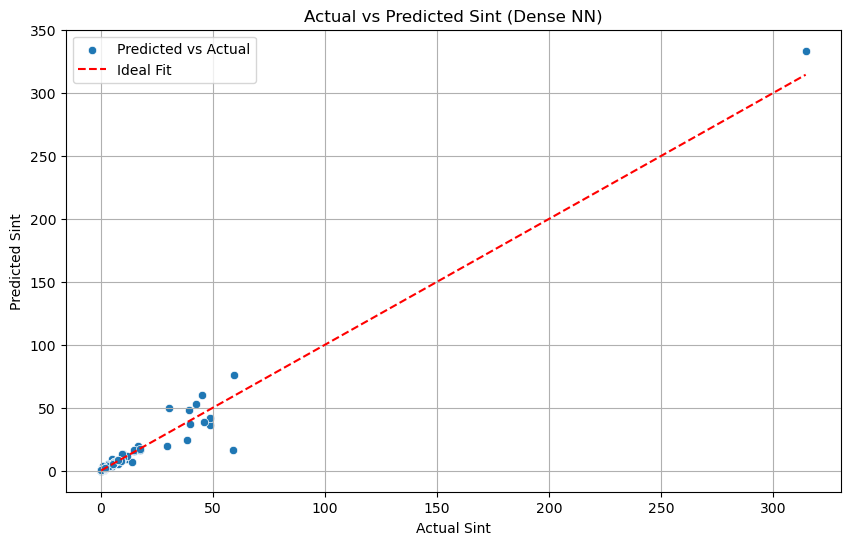

In [4]:
# -----------------------------
# Predictions & metrics
# -----------------------------
y_pred = model.predict(X_test).flatten()

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Accuracy-style percentages (same logic you used)
range_y = y_test.max() - y_test.min()
acc_mse  = (1 - mse  / range_y) * 100
acc_rmse = (1 - rmse / range_y) * 100
acc_mae  = (1 - mae  / range_y) * 100

print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'R-squared (R^2): {r2:.4f}')
print(f'Accuracy based on MSE:  {acc_mse:.2f}%')
print(f'Accuracy based on RMSE: {acc_rmse:.2f}%')
print(f'Accuracy based on MAE:  {acc_mae:.2f}%')

# -----------------------------
# Plot: Actual vs Predicted
# -----------------------------
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color='red', linestyle='--', label='Ideal Fit')
plt.xlabel('Actual Sint')
plt.ylabel('Predicted Sint')
plt.title('Actual vs Predicted Sint (Dense NN)')
plt.legend()
plt.grid(True)
plt.show()